<a href="https://colab.research.google.com/github/adspacheco/classificacao-fraturas/blob/main/analises_classificacao_fraturas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtenção dos Dados

In [1]:
%%capture
!wget https://github.com/adspacheco/classificacao-fraturas/raw/main/dataset/dataset.zip
!unzip /content/dataset.zip

# Bibliotecas e Constantes


In [2]:
%%capture
!wget https://raw.githubusercontent.com/adspacheco/classificacao-fraturas/main/utils.py

In [3]:
!pip install keras-visualizer

In [4]:
import utils
import glob
import pandas as pd
import time
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [5]:
BASE_PATH = '/content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x'

# Exploração da Estrutura dos Arquivos

In [6]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x

'Avulsion fracture'	'Greenstick fracture'  'Longitudinal fracture'	'Spiral Fracture'
'Comminuted fracture'	'Hairline Fracture'    'Oblique fracture'
'Fracture Dislocation'	'Impacted fracture'    'Pathological fracture'


Cada tipo de fratura possui um diretório único.

In [7]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/Avulsion\ fracture

Test  Train


O tipo de fratura "Avulsion fracture" tem uma pasta test/train associada.

In [8]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/Avulsion\ fracture/Test

000002_png.rf.c3e00ebc2db78bc94e644c3f6605dad0.jpg
05cc2e0302957e0ad27edb6b9ffbc2_jumbo_jpg.rf.c15eb3758845b639f3aaba73c373501d.jpg
13256_2019_2325_Fig1_HTML_png.rf.09368fddb2da3979a35a0cac6f45.jpg
13256_2019_2325_Fig1_HTML_png.rf.09368fddb2da3979a3e1e25a0cac6f45.jpg
1b62e6fbfbc5a2f70c6af413189cfc82_jpg.rf.2761e933cc6d206308877cccaf0642b2.jpg
1-s2-0-S0899707114002836-gr2_jpg.rf.bb8ed4dee892edbb760f6ce687d74ba5.jpg
220px-Avulsion_fracture_of_tibial_tuberosity2C_annotated_jpg.rf.aac7ac1f6ad2f7a822ee729f39b750af.jpg
31446tn_jpg.rf.fd1466bd9c9a7d604dc3e782f87b84d6.jpg
389382_jpg.rf.8cb98ee798766a2d3f6a76279ba5d0d9.jpg
5c7fec45769db28bdd107336f19004336689a4fb804b37af3096741f2879ff02_jumbo_jpeg.rf.68a4d14a09ed5baf1f8e1c1957ee5a01.jpg
60683ca7a8a5848feda86d15_acl-avulsion-fracture-1_jpg.rf.17e17d797643e92164cc9825dc530399.jpg
9896089d1b31b0ba0158dc33122899_jumbo_jpeg.rf.d5e6b871460129728d2506e55476d496.jpg
9dcddacffaff8689cc1e9cedbe76a5_jumbo_jpeg.rf.7259a238161cf03dca23a3dd5369e0b1.jpg
avuls

Dentro do diretório Test do tipo de fratura "Avulsion fracture" tem o arquivo da imagem, todas com extensão .jpg

# Validação da Estrutura dos Arquivos
- Toda pasta (tipo de fratura) tem train/test associada
- Todos arquivos (imagens das fraturas) são .jpg
- Visualização dos arquivos se é de fato imagem de fraturas

Todos os diretórios possuem 'Train' e 'Test', e todos os arquivos são .jpg, alguns arquivos de exemplo:

Exemplos de arquivos:
/content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/Oblique fracture/Train/Initial-radiographs-Oblique-spiral-fracture-is-observed-in-the-diaphysis-of-tibia_jpg.rf.9658444cad8609971c790aab2d8dced0.jpg


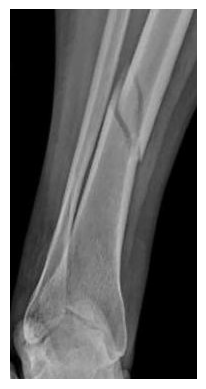

/content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/Fracture Dislocation/Train/jfmk-07-00030-g001_png.1e8d66777.jpg


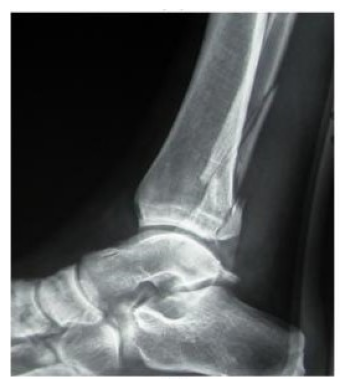

/content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/Greenstick fracture/Train/A-Initial-fracture-radiograph-showing-a-greenstick-fracture-B-Follow-up-radiograph_png.a7b09117eb778be10771416.jpg


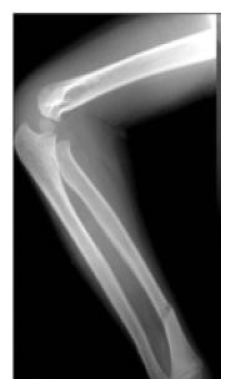

In [9]:
utils.validate_and_list_files(BASE_PATH)

# Quantidade de arquivos

In [10]:
initial_counts = utils.count_files_and_calculate_percentages(BASE_PATH)

Diretório: Hairline Fracture - Total: 111
  Train files: 101 (90.99%)
  Test files: 10 (9.01%)
Diretório: Avulsion fracture - Total: 123
  Train files: 109 (88.62%)
  Test files: 14 (11.38%)
Diretório: Pathological fracture - Total: 134
  Train files: 116 (86.57%)
  Test files: 18 (13.43%)
Diretório: Impacted fracture - Total: 84
  Train files: 75 (89.29%)
  Test files: 9 (10.71%)
Diretório: Fracture Dislocation - Total: 156
  Train files: 137 (87.82%)
  Test files: 19 (12.18%)
Diretório: Greenstick fracture - Total: 122
  Train files: 106 (86.89%)
  Test files: 16 (13.11%)
Diretório: Longitudinal fracture - Total: 80
  Train files: 68 (85.00%)
  Test files: 12 (15.00%)
Diretório: Oblique fracture - Total: 85
  Train files: 69 (81.18%)
  Test files: 16 (18.82%)
Diretório: Spiral Fracture - Total: 86
  Train files: 74 (86.05%)
  Test files: 12 (13.95%)
Diretório: Comminuted fracture - Total: 148
  Train files: 134 (90.54%)
  Test files: 14 (9.46%)

Resumo:
  Total Train: 989 (87.60%)
  

# Padronização dos Arquivos

In [11]:
old_to_new_dir_names = utils.rename_directories_and_files(BASE_PATH)

print("\nContagem de arquivos depois da padronização:")

new_counts = utils.count_files_and_calculate_percentages(BASE_PATH, train_name='train', test_name='test')

utils.validate_counts(initial_counts, new_counts, old_to_new_dir_names)


Contagem de arquivos depois da padronização:
Diretório: longitudinal - Total: 80
  Train files: 68 (85.00%)
  Test files: 12 (15.00%)
Diretório: fracture_dislocation - Total: 156
  Train files: 137 (87.82%)
  Test files: 19 (12.18%)
Diretório: comminuted - Total: 148
  Train files: 134 (90.54%)
  Test files: 14 (9.46%)
Diretório: avulsion - Total: 123
  Train files: 109 (88.62%)
  Test files: 14 (11.38%)
Diretório: oblique - Total: 85
  Train files: 69 (81.18%)
  Test files: 16 (18.82%)
Diretório: hairline - Total: 111
  Train files: 101 (90.99%)
  Test files: 10 (9.01%)
Diretório: pathological - Total: 134
  Train files: 116 (86.57%)
  Test files: 18 (13.43%)
Diretório: impacted - Total: 84
  Train files: 75 (89.29%)
  Test files: 9 (10.71%)
Diretório: greenstick - Total: 122
  Train files: 106 (86.89%)
  Test files: 16 (13.11%)
Diretório: spiral - Total: 86
  Train files: 74 (86.05%)
  Test files: 12 (13.95%)

Resumo:
  Total Train: 989 (87.60%)
  Total Test: 140 (12.40%)

Padroniza

In [12]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x

avulsion    fracture_dislocation  hairline  longitudinal  pathological
comminuted  greenstick		  impacted  oblique	  spiral


In [13]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/avulsion

test  train


In [14]:
!ls /content/classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x/avulsion/test

avulsion_110.jpg  avulsion_113.jpg  avulsion_116.jpg  avulsion_119.jpg	avulsion_122.jpg
avulsion_111.jpg  avulsion_114.jpg  avulsion_117.jpg  avulsion_120.jpg	avulsion_123.jpg
avulsion_112.jpg  avulsion_115.jpg  avulsion_118.jpg  avulsion_121.jpg


# Criação do Dataframe

In [15]:
image_files = glob.glob(f'{BASE_PATH}/**/*.jpg', recursive=True)

In [16]:
df = pd.DataFrame(image_files, columns=['full_path'])
df.head()

,full_path
0,/content/classificacao-imagem-tipos-fraturas-o...
1,/content/classificacao-imagem-tipos-fraturas-o...
2,/content/classificacao-imagem-tipos-fraturas-o...
3,/content/classificacao-imagem-tipos-fraturas-o...
4,/content/classificacao-imagem-tipos-fraturas-o...


In [17]:
aux = df.iloc[0]['full_path']
aux = aux.split('/')
aux

['',
 'content',
 'classificacao-imagem-tipos-fraturas-ossos-imagens-raio-x',
 'longitudinal',
 'train',
 'longitudinal_047.jpg']

In [18]:
df['type_dataset'] = df.full_path.apply(lambda x: x.split('/')[-2])
df['target'] = df.full_path.apply(lambda x: x.split('/')[-3])
df['filename'] = df.full_path.apply(lambda x: x.split('/')[-1])

In [19]:
df.sample(5).T

,1077,105,191,405,83
full_path,/content/classificacao-imagem-tipos-fraturas-o...,/content/classificacao-imagem-tipos-fraturas-o...,/content/classificacao-imagem-tipos-fraturas-o...,/content/classificacao-imagem-tipos-fraturas-o...,/content/classificacao-imagem-tipos-fraturas-o...
type_dataset,train,train,train,train,train
target,spiral,fracture_dislocation,fracture_dislocation,avulsion,fracture_dislocation
filename,spiral_032.jpg,fracture_dislocation_030.jpg,fracture_dislocation_081.jpg,avulsion_073.jpg,fracture_dislocation_083.jpg


In [20]:
df.type_dataset.value_counts(1)

type_dataset
train    0.875996
test     0.124004
Name: proportion, dtype: float64

In [21]:
df.value_counts(['type_dataset', 'target']).to_frame()

count
type_dataset target                     
train        fracture_dislocation    137
             comminuted              134
             pathological            116
             avulsion                109
             greenstick              106
             hairline                101
             impacted                 75
             spiral                   74
             oblique                  69
             longitudinal             68
test         fracture_dislocation     19
             pathological             18
             oblique                  16
             greenstick               16
             comminuted               14
             avulsion                 14
             spiral                   12
             longitudinal             12
             hairline                 10
             impacted                  9

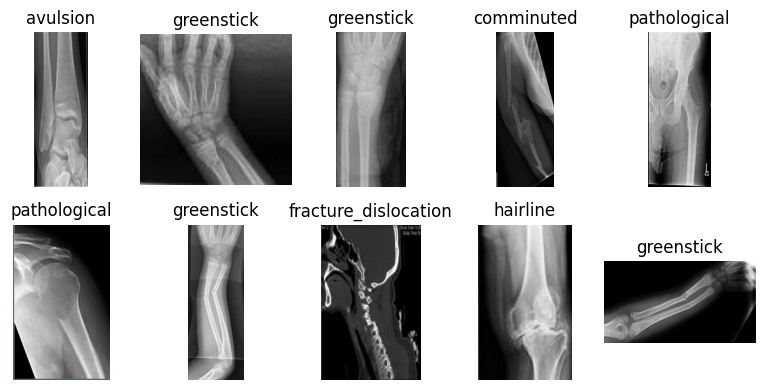

In [22]:
utils.plot_random_imgs(df)

1. Converter Array
2. Resize
3. Normalizar

In [23]:
new_imgs_size = (32, 32)

imgs_train, targets_train, imgs_test, targets_test = utils.process_images(df, new_imgs_size)

# Verificar se as imagens foram processadas corretamente
print(f"Número de imagens de treino: {len(imgs_train)}, Número de imagens de teste: {len(imgs_test)}")

Número de imagens de treino: 989, Número de imagens de teste: 140


In [24]:
X_train = np.array(imgs_train)
y_train = np.array(targets_train)

X_test = np.array(imgs_test)
y_test = np.array(targets_test)

In [25]:
X_train.shape, X_test.shape

((989, 32, 32, 3), (140, 32, 32, 3))

In [26]:
# linhas, altura, largura, canais

In [27]:
y_train.shape, y_test.shape

((989,), (140,))

In [28]:
#new_path = "/content/dataset-serializado"

#!mkdir -p /content/dataset-serializado - dps alterar para o Drive

#save_obj(X_train, f'{new_path}/X_train.joblib')
#save_obj(X_test, f'{new_path}/X_test.joblib')
#save_obj(y_train, f'{new_path}/y_train.joblib')
#save_obj(y_test, f'{new_path}/y_test.joblib')

In [29]:
le = LabelEncoder()

y_train_encoder = le.fit_transform(y_train)
y_test_encoder = le.transform(y_test)

In [30]:
# Quantidade de Categorias
num_classes = 10

y_train_categorical = to_categorical(y_train_encoder, num_classes)
y_test_categorical = to_categorical(y_test_encoder, num_classes)

In [31]:
X_train.shape

(989, 32, 32, 3)

# CNN

In [32]:
input_shape = X_train[0].shape
input_shape

(32, 32, 3)

In [33]:
num_classes = y_train_categorical.shape[1]
num_classes

10

In [34]:
model = Sequential()

model.add(Conv2D(
    filters=32,
    kernel_size=(3, 3),
    activation='relu',
    input_shape=input_shape
))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 128)               1605760   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

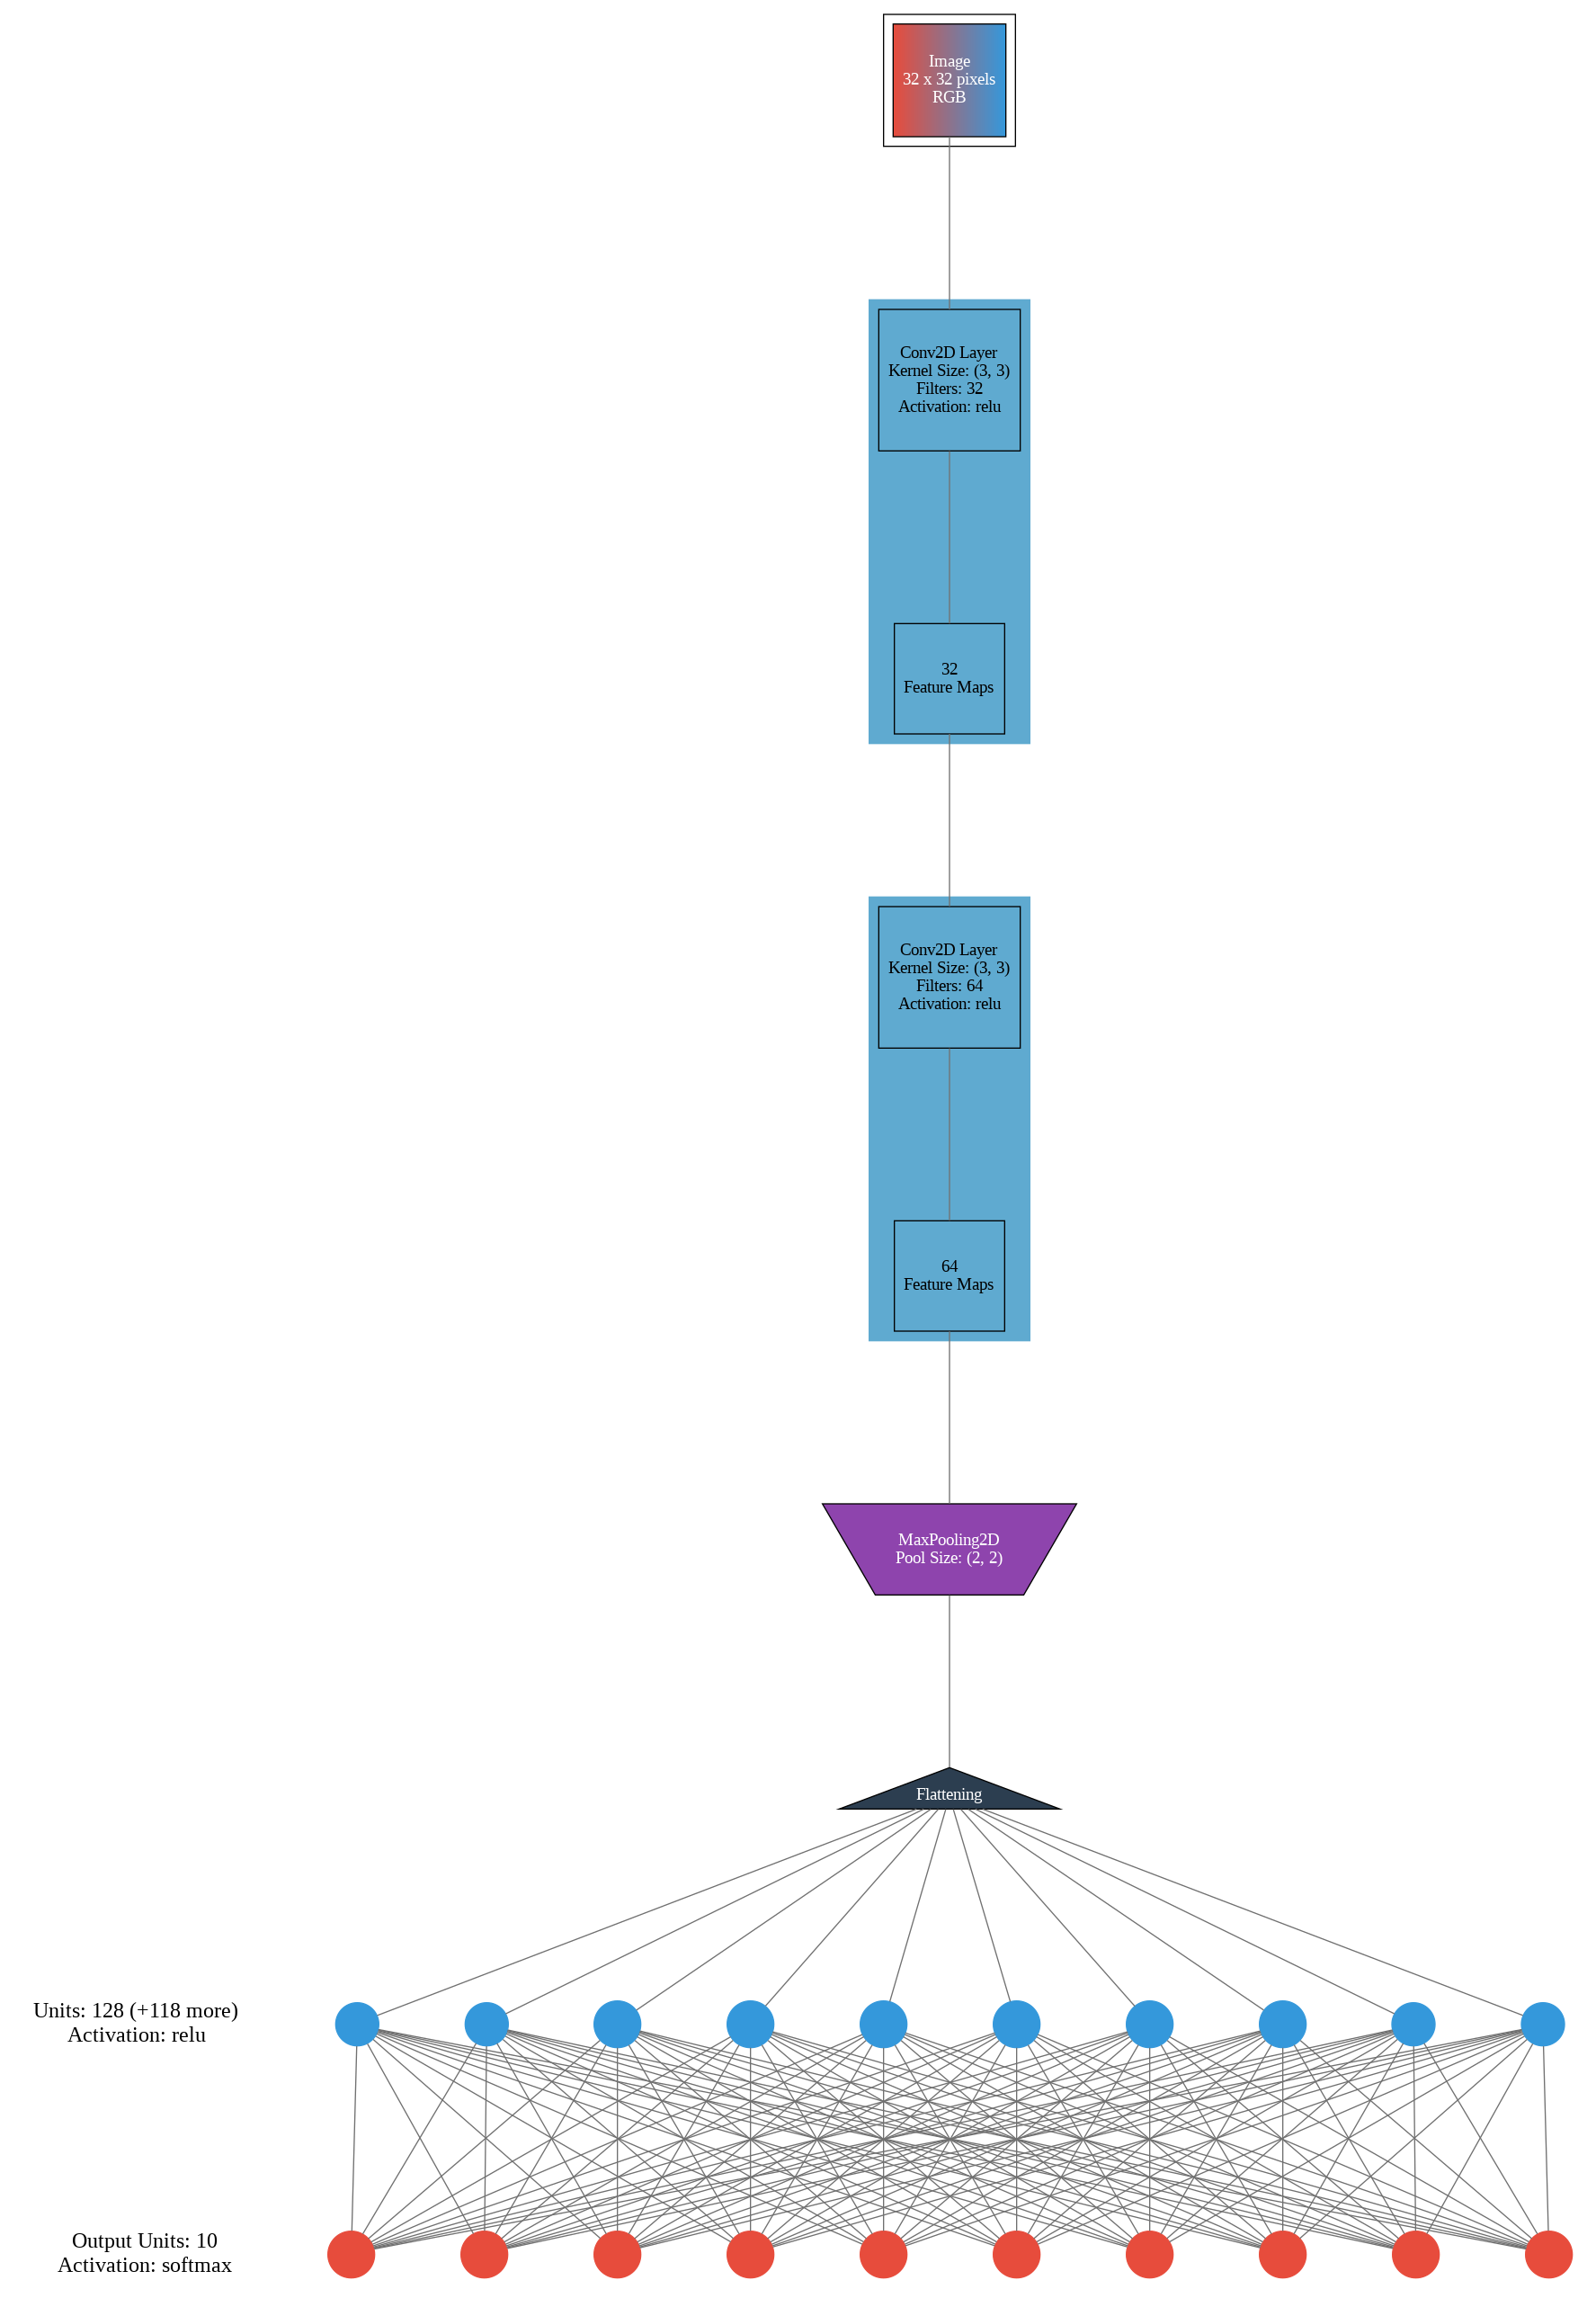

In [35]:
utils.plot_nn(model)

In [36]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
historico = model.fit(
    X_train,
    y_train_categorical,
    batch_size=32,
    epochs=25,
    verbose=1,
    validation_data=(X_test, y_test_categorical)
)

Epoch 1/25
31/31 [==============================] - 7s 145ms/step - loss: 2.2890 - accuracy: 0.1254 - val_loss: 2.2920 - val_accuracy: 0.0929
Epoch 2/25
31/31 [==============================] - 4s 123ms/step - loss: 2.1615 - accuracy: 0.2123 - val_loss: 2.3567 - val_accuracy: 0.0857
Epoch 3/25
31/31 [==============================] - 4s 126ms/step - loss: 2.0470 - accuracy: 0.2690 - val_loss: 2.3173 - val_accuracy: 0.1929
Epoch 4/25
31/31 [==============================] - 5s 164ms/step - loss: 1.8342 - accuracy: 0.3519 - val_loss: 2.3818 - val_accuracy: 0.1429
Epoch 5/25
31/31 [==============================] - 3s 104ms/step - loss: 1.5769 - accuracy: 0.4752 - val_loss: 2.4863 - val_accuracy: 0.2429
Epoch 6/25
31/31 [==============================] - 3s 103ms/step - loss: 1.3370 - accuracy: 0.5683 - val_loss: 2.7779 - val_accuracy: 0.2214
Epoch 7/25
31/31 [==============================] - 4s 114ms/step - loss: 1.0547 - accuracy: 0.6512 - val_loss: 2.8619 - val_accuracy: 0.2286
Epoch 

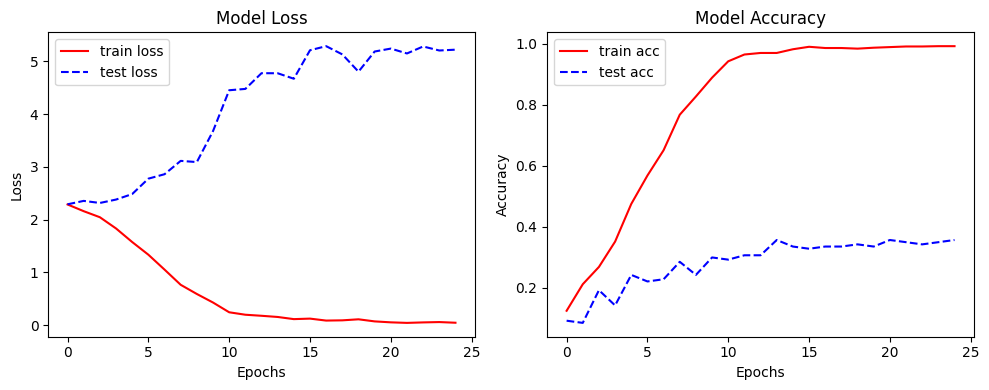

In [38]:
utils.plot_history(historico)

In [ ]:
# Deu mto ruim :)

In [39]:
model.evaluate(X_test, y_test_categorical)

5/5 [==============================] - 0s 23ms/step - loss: 5.2219 - accuracy: 0.3571


[5.221887588500977, 0.3571428656578064]

In [40]:
predictions = model.predict(X_test)

5/5 [==============================] - 0s 22ms/step


In [41]:
predicted_classes = np.argmax(predictions, axis=1)
max_probs = np.max(predictions, axis=1)

In [42]:
df_test = df[df['type_dataset'] == 'test'].copy().reset_index(drop=True)
df_test['predicted_class'] = le.inverse_transform(predicted_classes)
df_test['target_proba'] = max_probs.astype('float').round(3)

In [43]:
df_test.iloc[:, 1:].head(5) # para remover o full path

,type_dataset,target,filename,img_processada,predicted_class,target_proba
0,test,longitudinal,longitudinal_073.jpg,True,avulsion,0.626
1,test,longitudinal,longitudinal_069.jpg,True,longitudinal,0.992
2,test,longitudinal,longitudinal_078.jpg,True,avulsion,1.000
3,test,longitudinal,longitudinal_075.jpg,True,longitudinal,0.999
4,test,longitudinal,longitudinal_070.jpg,True,spiral,0.994


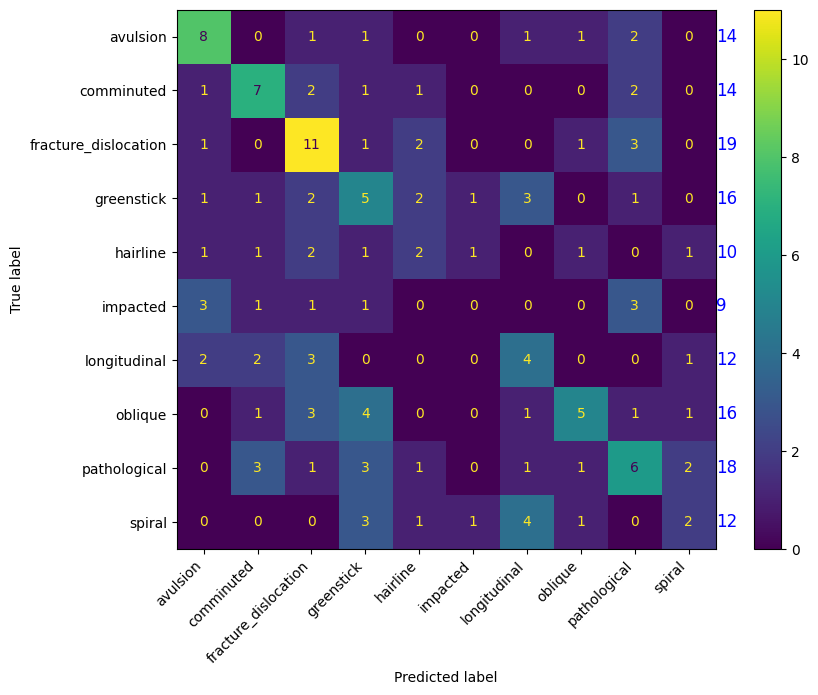

In [44]:
utils.plot_confusion_matrix_with_sums(df_test['target'], df_test['predicted_class'])

In [45]:
df_test.shape

(140, 7)

In [46]:
df_diff = df_test[df_test['target'] != df_test['predicted_class']].copy()

In [47]:
df_test.iloc[:, 1:].head(5) # para remover o full path

,type_dataset,target,filename,img_processada,predicted_class,target_proba
0,test,longitudinal,longitudinal_073.jpg,True,avulsion,0.626
1,test,longitudinal,longitudinal_069.jpg,True,longitudinal,0.992
2,test,longitudinal,longitudinal_078.jpg,True,avulsion,1.000
3,test,longitudinal,longitudinal_075.jpg,True,longitudinal,0.999
4,test,longitudinal,longitudinal_070.jpg,True,spiral,0.994


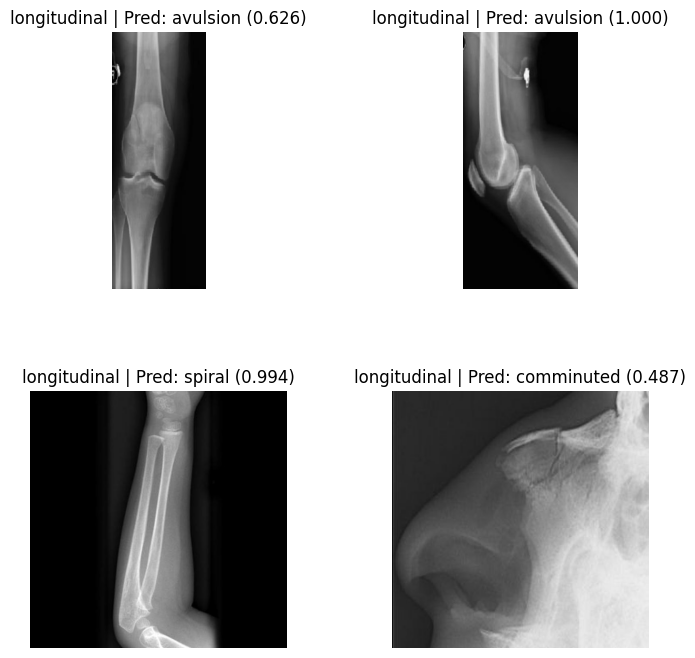

In [48]:
utils.plot_images_with_titles(df_diff)

In [49]:
# mto ruim msm :)

# Dataset tratado

Testando com novo dataset tratado no notebook pre_data_augmentation.ipynb

In [62]:
%%capture
!wget https://github.com/adspacheco/classificacao-fraturas/raw/main/dataset/dataset-aug.zip
!unzip /content/dataset-aug.zip -d /content/novo-dataset


In [64]:
BASE_PATH_AUG = "/content/novo-dataset"

In [65]:
image_files = glob.glob(f'{BASE_PATH_AUG}/**/*.jpg', recursive=True)
df2 = pd.DataFrame(image_files, columns=['full_path'])
df2.head()
aux = df2.iloc[0]['full_path']
aux = aux.split('/')
aux
df2['type_dataset'] = df2.full_path.apply(lambda x: x.split('/')[-2])
df2['target'] = df2.full_path.apply(lambda x: x.split('/')[-3])
df2['filename'] = df2.full_path.apply(lambda x: x.split('/')[-1])
df2.sample(5).T

,1439,546,649,34,1162
full_path,/content/novo-dataset/impacted/train/AUG_impac...,/content/novo-dataset/comminuted/train/AUG_com...,/content/novo-dataset/avulsion/train/avulsion_...,/content/novo-dataset/longitudinal/train/AUG_l...,/content/novo-dataset/hairline/train/hairline_...
type_dataset,train,train,train,train,train
target,impacted,comminuted,avulsion,longitudinal,hairline
filename,AUG_impacted_008_123.jpg,AUG_comminuted_020_165.jpg,avulsion_033.jpg,AUG_longitudinal_043_68.jpg,hairline_067.jpg


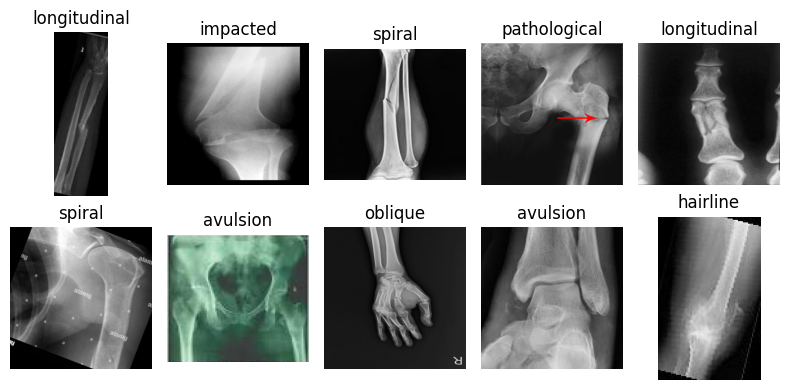

In [66]:
df2.value_counts(['type_dataset', 'target']).to_frame()
utils.plot_random_imgs(df2)

In [67]:
imgs_train, targets_train, imgs_test, targets_test = utils.process_images(df2, new_imgs_size)

# Verificar se as imagens foram processadas corretamente
print(f"Número de imagens de treino: {len(imgs_train)}, Número de imagens de teste: {len(imgs_test)}")

X_train = np.array(imgs_train)
y_train = np.array(targets_train)

X_test = np.array(imgs_test)
y_test = np.array(targets_test)

le = LabelEncoder()

y_train_encoder = le.fit_transform(y_train)
y_test_encoder = le.transform(y_test)

# Quantidade de Categorias
num_classes = 10

y_train_categorical = to_categorical(y_train_encoder, num_classes)
y_test_categorical = to_categorical(y_test_encoder, num_classes)

model = Sequential()

model.add(Conv2D(
    filters=32,
    kernel_size=(3, 3),
    activation='relu',
    input_shape=input_shape
))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()


Número de imagens de treino: 1700, Número de imagens de teste: 340
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1605760   
                                                                 
 dense_3 (Dense)             (None, 10)              

In [68]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [69]:
historico = model.fit(
    X_train,
    y_train_categorical,
    batch_size=32,
    epochs=25,
    verbose=1,
    validation_data=(X_test, y_test_categorical)
)

Epoch 1/25
54/54 [==============================] - 10s 153ms/step - loss: 2.3050 - accuracy: 0.0976 - val_loss: 2.2704 - val_accuracy: 0.1294
Epoch 2/25
54/54 [==============================] - 5s 101ms/step - loss: 2.1785 - accuracy: 0.2135 - val_loss: 2.2560 - val_accuracy: 0.1500
Epoch 3/25
54/54 [==============================] - 7s 123ms/step - loss: 1.9734 - accuracy: 0.2976 - val_loss: 2.2782 - val_accuracy: 0.1765
Epoch 4/25
54/54 [==============================] - 7s 121ms/step - loss: 1.7223 - accuracy: 0.4135 - val_loss: 2.4108 - val_accuracy: 0.2265
Epoch 5/25
54/54 [==============================] - 5s 101ms/step - loss: 1.4178 - accuracy: 0.5341 - val_loss: 2.5420 - val_accuracy: 0.2412
Epoch 6/25
54/54 [==============================] - 9s 165ms/step - loss: 1.0754 - accuracy: 0.6418 - val_loss: 2.9637 - val_accuracy: 0.2765
Epoch 7/25
54/54 [==============================] - 10s 178ms/step - loss: 0.7498 - accuracy: 0.7682 - val_loss: 3.1644 - val_accuracy: 0.2765
Epoc

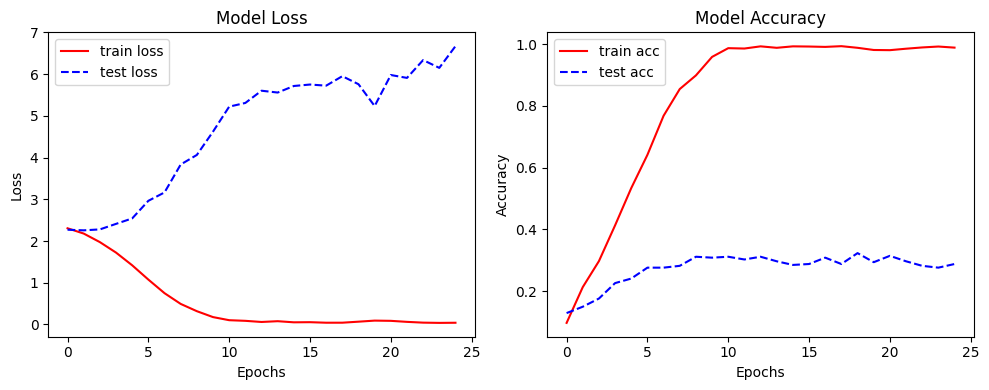

In [70]:
utils.plot_history(historico)